# The local unitary cluster Jastrow (LUCJ) ansatz

This page explains the local unitary cluster Jastrow (LUCJ) ansatz, which was originally introduced in [this paper](https://pubs.rsc.org/en/content/articlelanding/2023/sc/d3sc02516k). For a guide on simulating the LUCJ ansatz using ffsim, see [How to simulate the local unitary cluster Jastrow (LUCJ) ansatz](../how-to-guides/simulate-lucj.ipynb).

## The general unitary cluster Jastrow (UCJ) ansatz

The LUCJ ansatz is a specialized form of the general unitary cluster Jastrow (UCJ) ansatz, which has the form

$$
  \lvert \Psi \rangle = \prod_{k = 1}^L \mathcal{U}_k e^{i \mathcal{J}_k} \mathcal{U}_k^\dagger \lvert \Phi_0 \rangle
$$

where $\lvert \Phi_0 \rangle$ is a reference state, often taken as the Hartree-Fock state, each $\mathcal{U}_k$ is an [orbital rotation](orbital-rotation.ipynb), and each $\mathcal{J}_k$ is a diagonal Coulomb operator of the form

$$
    \mathcal{J} = \frac12\sum_{ij,\sigma \tau} \mathbf{J}^{\sigma \tau}_{ij} n_{i,\sigma} n_{j,\tau}.
$$

In ffsim, the UCJ ansatz is represented using classes that store the diagonal Coulomb matrices and orbital rotations as Numpy arrays. To facilitate variational optimization of the ansatzes, these classes implement methods for conversion to and from a vector of real-valued parameters. The parameter vector stores the entries of the UCJ matrices in a non-redundant way (for the orbital rotations, the parameter vector actually stores the entries of their logarithm).

### Spin-balanced and spin-unbalanced ansatzes

ffsim implements two variants of the UCJ ansatz, a "spin-balanced" ansatz, which is appropriate to apply to a closed-shell reference state, and a "spin-unbalanced" ansatz, which is appropriate to apply to an open-shell initial reference state.

In the spin-balanced ansatz, $\mathbf{J}^{\alpha\alpha} = \mathbf{J}^{\beta\beta}$ and $\mathbf{J}^{\alpha\beta} = \mathbf{J}^{\beta\alpha}$. As a result, each diagonal Coulomb operator is described by 2 matrices, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$, and both of these matrices are symmetric. The spin-balanced UCJ ansatz is represented by the [UCJOpSpinBalanced](../api/ffsim.rst#ffsim.UCJOpSpinBalanced) class.

In the spin-unbalanced ansatz, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\beta\beta}$ are allowed to differ, and $\mathbf{J}^{\alpha\beta}$ is no longer required to be symmetric. Since $\mathbf{J}^{\alpha\beta}_{ij} = \mathbf{J}^{\beta\alpha}_{ji}$, we don't need to store $\mathbf{J}^{\beta\alpha}$ separately. Therefore, each diagonal Coulomb operator is described by 3 matrices, $\mathbf{J}^{\alpha\alpha}$, $\mathbf{J}^{\alpha\beta}$, and $\mathbf{J}^{\beta\beta}$, and of these matrices, $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\beta\beta}$ are symmetric. The spin-unbalanced UCJ ansatz is represented by the [UCJOpSpinUnbalanced](../api/ffsim.rst#ffsim.UCJOpSpinUnbalanced) class.

## The local UCJ (LUCJ) ansatz

Implementing the $e^{i \mathcal{J}_k}$ term of the UCJ ansatz requires either all-to-all connectivity or the use of a fermionic swap network, making it challenging for noisy pre-fault-tolerant quantum processors that have limited connectivity. The idea of the *local* UCJ ansatz is to impose sparsity constraints on the $\mathbf{J}^{\alpha\alpha}$ and $\mathbf{J}^{\alpha\beta}$ matrices which allow them to be implemented in constant depth on qubit topologies with limited connectivity. The constraints are specified by a list of indices indicating which matrix entries in the upper triangle are allowed to be nonzero (since the matrices are symmetric, only the upper triangle needs to be specified). These indices can be interpreted as pairs of orbitals that are allowed to interact.

As an example, consider a square lattice qubit topology. We can place the $\alpha$ and $\beta$ orbitals in parallel lines on the lattice, with connections between these lines forming "rungs" of a ladder shape, like this:

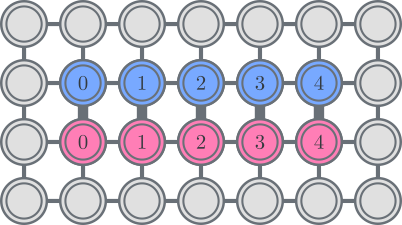

With this setup, orbitals with the same spin are connected with a line topology, while orbitals with different spins are connected when they share the same spatial orbital. This yields the following index constraints on the $\mathbf{J}$ matrices:

$$
\begin{align*}
\mathbf{J}^{\alpha\alpha} &: \set{(p, p+1) \; , \; p = 0, \ldots, N-2} \\
\mathbf{J}^{\alpha\beta} &: \set{(p, p) \;, \; p = 0, \ldots, N-1}
\end{align*}
$$

In other words, if the $\mathbf{J}$ matrices are nonzero only at the specified indices in the upper triangle, then the $e^{i \mathcal{J}_k}$ term can be implemented on a square topology without using any swap gates, in constant depth. Of course, imposing such constraints on the ansatz makes it less expressive, so more ansatz repetitions may be required.



## Parameter initialization from CCSD

The parameters of the (L)UCJ ansatz can be initialized from the results of a coupled cluster, singles and doubles (CCSD) calculation. This section explains how this initialization works, and how it's implemented in ffsim.

### CCSD and UCCSD

CCSD is a computational method that approximates the ground state wavefunction with an exponential ansatz,
$$
\lvert \Psi_\text{CCSD} \rangle = e^{T}\lvert \Phi_0 \rangle,
$$
where
$$
T = T_1 + T_2
$$
with
$$
T_1 = \sum_{ia} t_{ia} c^\dagger_i c_a, \quad
T_2 = \sum_{ijab} t_{ijab} c^\dagger_i c^\dagger_j c_a c_b.
$$
The ansatz is parameterized by the numbers $t_{ia}$ and $t_{ijab}$, called $t$-amplitudes (separately, $t_1$- and $t_2$-amplitudes), which can be efficiently solved for on a classical computer.

Unitary CCSD (UCCSD) is a variant of CCSD that uses a similar exponential ansatz, but with an operator that is guaranteed to be unitary,
$$
\lvert \Psi_\text{UCCSD} \rangle = e^{T - T^\dagger}\lvert \Phi_0 \rangle.
$$
While UCCSD is challenging to implement on a classical computer, it can be implemented efficiently on a quantum computer. Like CCSD, UCCSD is also parameterized by the $t$-amplitudes $t_{ia}$ and $t_{ijab}$. If the same $t$-amplitudes from CCSD are plugged into UCCSD, and $\lvert \Phi_0 \rangle$ is the Hartree-Fock state, then because $T^\dagger \lvert \Phi_0 \rangle = 0$, the resulting ansatz states match up to first order in $T$ in the Taylor series of the exponential operators. Therefore, the $t$-amplitudes obtained from a CCSD calculation may serve as a reasonable initial guess for UCCSD.

### From UCCSD to UCJ

The UCJ ansatz can be related to the UCCSD ansatz via a double-factorized representation the $T_2$ operator. We can focus on the $T_2$ operator because the $T_1$ operator can be separated by invoking a Trotter approximation:
$$
e^{T - T^\dagger} = e^{T_1 - T_1^\dagger + T_2 - T_2^\dagger} \approx e^{T_1 - T_1^\dagger} e^{T_2 - T_2^\dagger}.
$$
Because $T_1$ contains only quadratic terms, $e^{T_1 - T_1^\dagger}$ is an [orbital rotation](orbital-rotation.ipynb), so it can be implemented efficiently on a quantum computer. To approximate $e^{T_2 - T_2^\dagger}$, we represent $T_2 - T_2^\dagger$ in a double-factorized form,
$$
T_2 - T_2^\dagger = i\sum_{k=1}^L \mathcal{U}_k \mathcal{J}_k \mathcal{U}_k^\dagger.
$$
As with the [double-factorized representation of the molecular Hamiltonian](double-factorized.ipynb), here the $\mathcal{U}_k$ are orbital rotations and the $\mathcal{J}_k$ are diagonal Coulomb operators. Finally, to obtain an operator in UCJ form, we invoke a Trotter approximation:
$$
e^{T_2 - T_2^\dagger} = e^{i\sum_{k=1}^L \mathcal{U}_k \mathcal{J}_k \mathcal{U}_k^\dagger} \approx \prod_{k=1}^L \mathcal{U}_k e^{i\mathcal{J}_k} \mathcal{U}_k^\dagger.
$$
Thus, the $t$-amplitudes obtained from a CCSD calculation may also yield an initial guess for UCJ via double-factorization of the $t_2$-amplitudes. If a final orbital rotation is included in the ansatz, it can be initialized from the $t_1$-amplitudes.

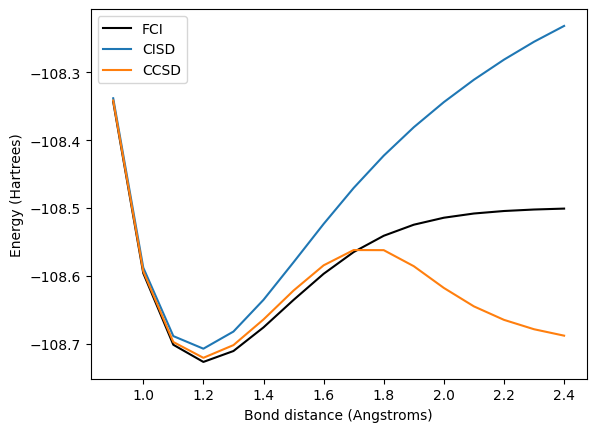

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyscf.cc
import pyscf.ci
import pyscf.mcscf

import ffsim

# Set bond distance range for N2 molecule
start = 0.9
stop = 2.4
step = 0.1
bond_distance_range = np.linspace(start, stop, num=round((stop - start) / step) + 1)

mol_datas = []
for bond_distance in bond_distance_range:
    # Build molecule
    mol = pyscf.gto.Mole()
    mol.build(
        atom=[("N", (-0.5 * bond_distance, 0, 0)), ("N", (0.5 * bond_distance, 0, 0))],
        basis="sto-6g",
        symmetry="Dooh",
        verbose=0,
    )
    # Run Hartree-Fock
    scf = pyscf.scf.RHF(mol)
    scf.kernel()
    # Get molecular integrals
    active_space = list(range(2, mol.nao_nr()))
    norb = len(active_space)
    nelectron_cas = int(sum(scf.mo_occ[active_space]))
    n_alpha = (nelectron_cas + mol.spin) // 2
    n_beta = (nelectron_cas - mol.spin) // 2
    nelec = (n_alpha, n_beta)
    cas = pyscf.mcscf.RCASCI(scf, ncas=norb, nelecas=nelec)
    mo_coeff = cas.sort_mo(active_space, base=0)
    h1e_cas, ecore = cas.get_h1eff(mo_coeff=mo_coeff)
    h2e_cas = cas.get_h2eff(mo_coeff=mo_coeff)
    # Run FCI
    cas.fix_spin_(ss=0)
    cas.kernel(mo_coeff=mo_coeff)
    # Run CISD
    cisd = pyscf.ci.RCISD(
        scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
    )
    cisd.kernel()
    # Run CCSD
    ccsd = pyscf.cc.RCCSD(
        scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
    )
    ccsd.kernel(
        # Initialize with t-amplitudes from previous iteration to improve convergence
        t1=mol_datas[-1].ccsd_t1 if mol_datas else None,
        t2=mol_datas[-1].ccsd_t2 if mol_datas else None,
    )
    # Store data
    mol_data = ffsim.MolecularData(
        norb=norb,
        nelec=nelec,
        core_energy=ecore,
        one_body_integrals=h1e_cas,
        two_body_integrals=h2e_cas,
        fci_energy=cas.e_tot,
        cisd_energy=cisd.e_tot,
        ccsd_energy=ccsd.e_tot,
        ccsd_t1=ccsd.t1,
        ccsd_t2=ccsd.t2,
    )
    mol_datas.append(mol_data)

# Plot FCI, CISD, and CCSD energies
fig, ax = plt.subplots()
ax.plot(
    bond_distance_range,
    [mol_data.fci_energy for mol_data in mol_datas],
    "-",
    label="FCI",
    color="black",
)
ax.plot(
    bond_distance_range,
    [mol_data.cisd_energy for mol_data in mol_datas],
    "-",
    label="CISD",
)
ax.plot(
    bond_distance_range,
    [mol_data.ccsd_energy for mol_data in mol_datas],
    "-",
    label="CCSD",
)
ax.set_xlabel("Bond distance (Angstroms)")
ax.set_ylabel("Energy (Hartrees)")
ax.legend()

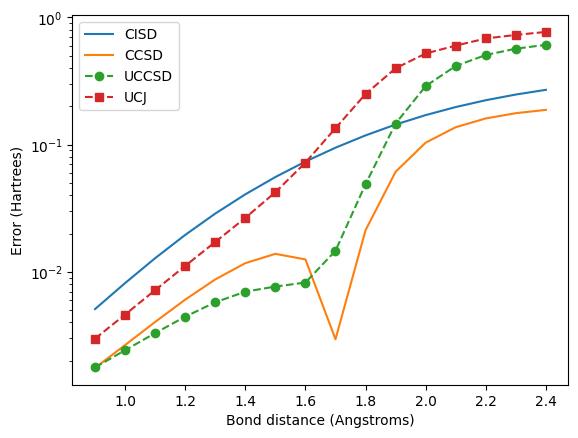

In [2]:
uccsd_errors = []
ucj_errors = []
for mol_data in mol_datas:
    # Get molecular Hamiltonian as SciPy LinearOperator
    linop = ffsim.linear_operator(mol_data.hamiltonian, norb=norb, nelec=nelec)
    # Initialize reference state as Hartree-Fock state
    reference_state = ffsim.hartree_fock_state(norb, nelec)
    # Compute UCCSD energy initialized with CCSD t-amplitudes
    uccsd_op = ffsim.UCCSDOpRestrictedReal(t1=mol_data.ccsd_t1, t2=mol_data.ccsd_t2)
    final_state = ffsim.apply_unitary(reference_state, uccsd_op, norb=norb, nelec=nelec)
    uccsd_energy = np.vdot(final_state, linop @ final_state).real
    uccsd_errors.append(uccsd_energy - mol_data.fci_energy)
    # Compute UCJ energy initialized with CCSD t-amplitudes
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2, t1=mol_data.ccsd_t1
    )
    final_state = ffsim.apply_unitary(reference_state, ucj_op, norb=norb, nelec=nelec)
    ucj_energy = np.vdot(final_state, linop @ final_state).real
    ucj_errors.append(ucj_energy - mol_data.fci_energy)

# Plot energy errors
fig, ax = plt.subplots()
ax.plot(
    bond_distance_range,
    [mol_data.cisd_energy - mol_data.fci_energy for mol_data in mol_datas],
    "-",
    label="CISD",
)
ax.plot(
    bond_distance_range,
    # Take absolute value because CCSD energy is not variational
    [abs(mol_data.ccsd_energy - mol_data.fci_energy) for mol_data in mol_datas],
    "-",
    label="CCSD",
)
ax.plot(bond_distance_range, uccsd_errors, "o--", label="UCCSD")
ax.plot(bond_distance_range, ucj_errors, "s--", label="UCJ")
ax.set_yscale("log")
ax.set_xlabel("Bond distance (Angstroms)")
ax.set_ylabel("Error (Hartrees)")
ax.legend()

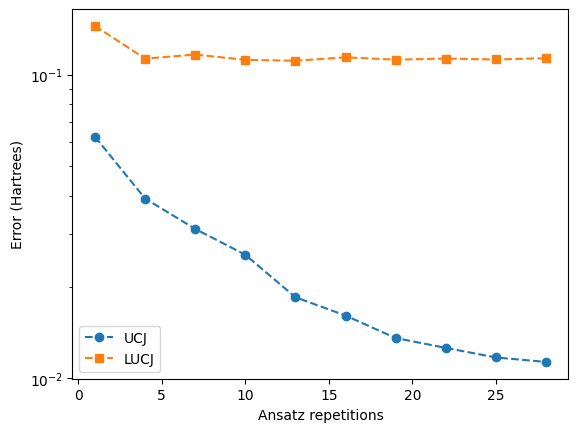

In [3]:
# Pick a specific bond length
bond_distance = 1.2
mol_data = mol_datas[bond_distance_range.searchsorted(bond_distance)]

# Get molecular Hamiltonian as SciPy LinearOperator
linop = ffsim.linear_operator(mol_data.hamiltonian, norb=norb, nelec=nelec)
# Initialize reference state as Hartree-Fock state
reference_state = ffsim.hartree_fock_state(norb, nelec)

# For LUCJ, use interactions implementable on a square lattice
pairs_aa = [(p, p + 1) for p in range(norb - 1)]
pairs_ab = [(p, p) for p in range(norb)]

n_reps_range = range(1, ucj_op.n_reps + 1, 3)
ucj_errors_n_reps = []
lucj_errors_n_reps = []
for n_reps in n_reps_range:
    # Compute UCJ energy initialized with CCSD t-amplitudes
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2, t1=mol_data.ccsd_t1, n_reps=n_reps
    )
    final_state = ffsim.apply_unitary(reference_state, ucj_op, norb=norb, nelec=nelec)
    ucj_energy = np.vdot(final_state, linop @ final_state).real
    ucj_errors_n_reps.append(ucj_energy - mol_data.fci_energy)
    # Compute LUCJ energy initialized with CCSD t-amplitudes
    lucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2,
        t1=mol_data.ccsd_t1,
        n_reps=n_reps,
        interaction_pairs=(pairs_aa, pairs_ab),
    )
    final_state = ffsim.apply_unitary(reference_state, lucj_op, norb=norb, nelec=nelec)
    lucj_energy = np.vdot(final_state, linop @ final_state).real
    lucj_errors_n_reps.append(lucj_energy - mol_data.fci_energy)

# Plot energy errors
fig, ax = plt.subplots()
ax.plot(n_reps_range, ucj_errors_n_reps, "o--", label="UCJ")
ax.plot(n_reps_range, lucj_errors_n_reps, "s--", label="LUCJ")
ax.set_yscale("log")
ax.set_xlabel("Ansatz repetitions")
ax.set_ylabel("Error (Hartrees)")
ax.legend()

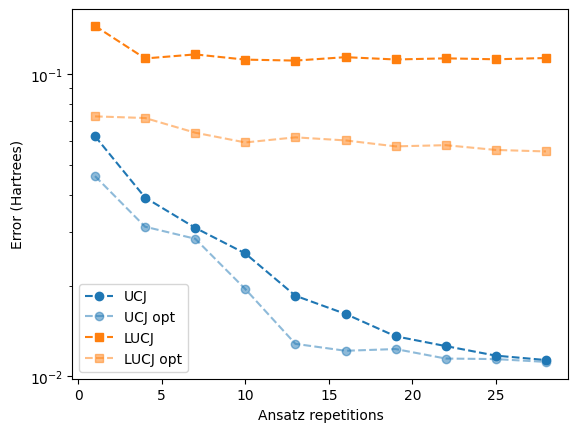

In [4]:
ucj_opt_errors_n_reps = []
lucj_opt_errors_n_reps = []
for n_reps in n_reps_range:
    # Compute "compressed" UCJ energy initialized with CCSD t-amplitudes
    ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2,
        t1=mol_data.ccsd_t1,
        n_reps=n_reps,
        optimize=True,
        options=dict(maxiter=10),
    )
    final_state = ffsim.apply_unitary(reference_state, ucj_op, norb=norb, nelec=nelec)
    ucj_energy = np.vdot(final_state, linop @ final_state).real
    ucj_opt_errors_n_reps.append(ucj_energy - mol_data.fci_energy)
    # Compute "compressed" LUCJ energy initialized with CCSD t-amplitudes
    lucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2=mol_data.ccsd_t2,
        t1=mol_data.ccsd_t1,
        n_reps=n_reps,
        interaction_pairs=(pairs_aa, pairs_ab),
        optimize=True,
        options=dict(maxiter=10),
    )
    final_state = ffsim.apply_unitary(reference_state, lucj_op, norb=norb, nelec=nelec)
    lucj_energy = np.vdot(final_state, linop @ final_state).real
    lucj_opt_errors_n_reps.append(lucj_energy - mol_data.fci_energy)

# Plot energy errors
fig, ax = plt.subplots()
(line,) = ax.plot(n_reps_range, ucj_errors_n_reps, "o--", label="UCJ")
ax.plot(
    n_reps_range,
    ucj_opt_errors_n_reps,
    "o--",
    alpha=0.5,
    color=line.get_color(),
    label="UCJ opt",
)
(line,) = ax.plot(n_reps_range, lucj_errors_n_reps, "s--", label="LUCJ")
(line,) = ax.plot(
    n_reps_range,
    lucj_opt_errors_n_reps,
    "s--",
    alpha=0.5,
    color=line.get_color(),
    label="LUCJ opt",
)
ax.set_yscale("log")
ax.set_xlabel("Ansatz repetitions")
ax.set_ylabel("Error (Hartrees)")
ax.legend()

According to the plot, CCSD t2 amplitudes provide good initial paramters for the UCJ ansatz. However, LUCJ anstaz requires truncating the interaction terms. In addition, when implementing on the pre-fault-tolerant quantum processors, we often need to limit the number of layers, which introduces more errors due to reduced circuit expressiveness. 

The following code demonstrates the truncation errors caused by 1. limited connectivity by comparing the UCJ ansatz and LUCJ ansatz with square connectivity and, 2. limited circuit depth by comparing the ansatzes with different numbers of layers (x-axis).

In [ ]:
# Build N2 molecule with R=1.2Å
atom = [("N", (-0.6, 0, 0)), ("N", (0.6, 0, 0))]
mol = pyscf.gto.Mole()
mol.build(
    atom=atom,
    basis="sto-6g",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular data and Hamiltonian
scf = pyscf.scf.RHF(mol).run()
mol_data = ffsim.MolecularData.from_scf(scf, active_space=active_space)
norb, nelec = mol_data.norb, mol_data.nelec
mol_hamiltonian = mol_data.hamiltonian

# run CCSD
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
ccsd_energy.append(ccsd.e_tot)

t2 = ccsd.t2
t1 = ccsd.t1


reference_state = ffsim.hartree_fock_state(norb, nelec)

# Use interactions implementable on a square lattice
pairs_aa = [(p, p + 1) for p in range(norb - 1)]
pairs_ab = [(p, p) for p in range(norb)]

# fci energy reference
cisolver = pyscf.fci.FCI(scf)
fci_energy_reference = cisolver.kernel()[0]

operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2,
    t1=t1,
)


# function to compute the difference with the original t2 amplitude
# with a least-squares objective function.
def loss(op, interaction_pairs=None):
    nocc, _, _, _ = t2.shape
    orbital_rotations = op.orbital_rotations
    diag_coulomb_mats = np.zeros(orbital_rotations.shape)
    if interaction_pairs is not None:
        pairs_aa, pairs_ab = interaction_pairs
        rows, cols = zip(*pairs_aa)
        diag_coulomb_mats[:, rows, cols] = op.diag_coulomb_mats[:, 0, rows, cols]
        diag_coulomb_mats[:, cols, rows] = op.diag_coulomb_mats[:, 0, rows, cols]
        rows, cols = zip(*pairs_ab)
        diag_coulomb_mats[:, rows, cols] = op.diag_coulomb_mats[:, 1, rows, cols]
        diag_coulomb_mats[:, cols, rows] = op.diag_coulomb_mats[:, 1, rows, cols]
    else:
        diag_coulomb_mats = op.diag_coulomb_mats[:, 0]

    reconstructed = (
        1j
        * np.einsum(
            "mpq,map,mip,mbq,mjq->ijab",
            diag_coulomb_mats,
            orbital_rotations,
            orbital_rotations.conj(),
            orbital_rotations,
            orbital_rotations.conj(),
            optimize="greedy",
        )[:nocc, :nocc, nocc:, nocc:]
    )
    diff = reconstructed - t2
    return 0.5 * np.sum(np.abs(diff) ** 2)


ucj_energy_error = []
lucj_energy_error = []
ucj_loss = []
lucj_loss = []
n_reps_range = list(range(1, 10, 2)) + [10, 20, 30]
for n_reps in n_reps_range:
    # run UCJ
    # use CCSD to initialize parameters
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2, t1=t1, n_reps=n_reps)
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, linop @ final_state).real
    ucj_energy_error.append(energy - fci_energy_reference)
    ucj_loss.append(loss(operator))

    # run LUCJ
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2, t1=t1, n_reps=n_reps, interaction_pairs=(pairs_aa, pairs_ab)
    )
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, linop @ final_state).real
    lucj_energy_error.append(energy - fci_energy_reference)
    lucj_loss.append(loss(operator, (pairs_aa, pairs_ab)))

# plot energy
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    n_reps_range,
    ucj_energy_error,
    "--",
    label="UCJ",
    color="green",
)
plt.plot(
    n_reps_range,
    lucj_energy_error,
    "--",
    label="LUCJ-square",
    color="red",
)
plt.title("N$_2$ / sto-6g (6e,8o) VQE Energy")
plt.legend()
plt.yscale("log")
plt.show()

# plot loss
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    n_reps_range,
    ucj_loss,
    "--",
    label="UCJ",
    color="green",
)
plt.plot(
    n_reps_range,
    lucj_loss,
    "--",
    label="LUCJ-square",
    color="red",
)
plt.title("N$_2$ / sto-6g (6e,8o) Operator Loss")
plt.legend()
plt.show()

As shown in the figure, these truncations increase operator loss and energy error. As the circuits lack sufficient terms to fully capture interaction, the resulting wavefunctions are overly concentrated around the Hartree-Fock state. To mitigate this, we can "compress" the t2 amplitudes to fit within the desired circuit depth and connectivity by optimizing the coefficients of the remaining operators to recover the original t2 amplitudes with a least sqaures loss function
$$
||T_2-\bar{T_2}||_2,
$$
where $\bar{T_2}$ is reconstructed by the comprressed operator according to the relation 
$$
\bar{t}_{ijab} = \sum_k\sum_{pq} J^k_{pq} U^k_{ap} U^{k*}_{ip}U^k_{nq} U^{k*}_{iq}.
$$

The following code demonstrates that the compression techqnique can effectively recover the original amplitudes by reducing operator loss and thus improve the energy. To improve VQE energy, we incorporate a regularization term for the operator norm to our loss function to mitigate the increase of the Trotterization error due to large operator norm:
$$
\lambda\cdot(\sum_{k=1}^L||\bar{J}||_2-\sum_{k=1}^N||J||_2).
$$

In [ ]:
ucj_compressed_no_reg_energy_error = []
ucj_compressed_no_reg_loss = []
ucj_compressed_energy_error = []
ucj_compressed_loss = []
lucj_compressed_square_energy_error = []
lucj_compressed_square_loss = []

n_reps_range = list(range(1, 10, 2)) + [10, 20, 30]
for n_reps in n_reps_range:
    # use CCSD to initialize parameters
    # compress UCJ without regularization
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2,
        t1=t1,
        n_reps=n_reps,
        optimize=True,  # enable compression
        options={"maxiter": 100},
    )
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, linop @ final_state).real
    ucj_compressed_no_reg_energy_error.append(energy - fci_energy_reference)
    ucj_compressed_no_reg_loss.append(loss(operator))

    # compress UCJ with regularization
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2,
        t1=t1,
        n_reps=n_reps,
        optimize=True,  # enable compression
        options={"maxiter": 100},
        regularization=1e-3,
    )
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, linop @ final_state).real
    ucj_compressed_energy_error.append(energy - fci_energy_reference)
    ucj_compressed_loss.append(loss(operator))

    # compress UCJ with regularization for square connectivity
    operator = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
        t2,
        t1=t1,
        n_reps=n_reps,
        interaction_pairs=(pairs_aa, pairs_ab),
        optimize=True,  # enable compression
        options={"maxiter": 100},
        regularization=1e-3,
    )
    final_state = ffsim.apply_unitary(reference_state, operator, norb=norb, nelec=nelec)
    energy = np.vdot(final_state, linop @ final_state).real
    lucj_compressed_square_energy_error.append(energy - fci_energy_reference)
    lucj_compressed_square_loss.append(loss(operator, (pairs_aa, pairs_ab)))


# plot energy
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    n_reps_range,
    ucj_energy_error,
    "--",
    label="UCJ",
    color="green",
)
plt.plot(
    n_reps_range,
    lucj_energy_error,
    "--",
    label="LUCJ-square",
    color="red",
)
plt.plot(
    n_reps_range,
    ucj_compressed_no_reg_energy_error,
    "--",
    label="UCJ-compressed-no-reg",
    color="orange",
)
plt.plot(
    n_reps_range,
    ucj_compressed_energy_error,
    "--",
    label="UCJ-compressed",
    color="purple",
)
plt.plot(
    n_reps_range,
    lucj_compressed_square_energy_error,
    "--",
    label="LUCJ-compressed-square",
    color="blue",
)
plt.title("N$_2$ / sto-6g (6e,8o) VQE Energy")
plt.legend()
plt.yscale("log")
plt.show()


# plot loss
fig = plt.figure(figsize=(5, 4), layout="constrained")
plt.plot(
    n_reps_range,
    ucj_loss,
    "--",
    label="UCJ",
    color="green",
)
plt.plot(
    n_reps_range,
    ucj_compressed_no_reg_loss,
    "--",
    label="UCJ-compressed-no-reg",
    color="orange",
)
plt.plot(
    n_reps_range,
    ucj_compressed_loss,
    "--",
    label="UCJ-compressed",
    color="purple",
)
plt.plot(
    n_reps_range,
    lucj_loss,
    "--",
    label="LUCJ-square",
    color="red",
)
plt.plot(
    n_reps_range,
    lucj_compressed_square_loss,
    "--",
    label="LUCJ-compressed-square",
    color="blue",
)
plt.title("N$_2$ / sto-6g (6e,8o) Operator Loss")
plt.legend()
plt.show()

As shown in the picture, compression can effectively reduce the loss to the original t2 amplitude. However, without regularzation, we do not see a consistent improvement desipte the small operator loss. With regularization, the compressed operators consistently deliver more accurate energy estimation with the VQE method compared to the truncated operators.